In [19]:
import os
import json
import numpy as np
import pandas as pd
from time import time, strftime
from sklearn.metrics import precision_recall_fscore_support 
import pickle
def save_preds(preds, cb=False):
    preds = np.ravel(preds)
    assert len(preds)==338489
    avg = np.average(preds)
    std = np.std(preds)
    p = '../%s%s_dnn_tl_result_%.4f_%.4f_%s.csv' % ('callback_' if cb else '', 
        strftime('%H%M_%m%d'), avg, std, 'no_mess')

    df = pd.DataFrame({'instanceID': te_df_['instanceID'].values, 'proba': preds})
    df.sort_values('instanceID', inplace=True)
    df.to_csv(p, index=False)

    if cb: 
        print(' Written to: ', p)
        return avg, std
    else:
        print('\nTrain average: ', tr_avg)
        print('Preds average: ', avg)
        print('Preds std dev.: ', std)
        print('\nWritten to: ', p)

In [58]:
# data
# features = ['appCategory', 'positionID', 'positionType', 'creativeID', 'appID', 'adID',
#             'advertiserID', 'camgaignID', 'sitesetID', 'connectionType',
#             'residence', 'age', 'hometown', 'haveBaby', 'telecomsOperator',
#             'gender', 'education', 'clickTime_h', 'clickTime_d', 'weekDay',
#             'marriageStatus', 'appPlatform', 'clickTime_m', 'userID']

features = ['appCategory', 'positionType',  'appID', 'adID',
            'advertiserID', 'sitesetID', 'connectionType',
            'residence', 'age', 'haveBaby', 'telecomsOperator',
            'gender', 'education', 'clickTime_h', 'weekDay',
            'marriageStatus', 'appPlatform', 'clickTime_m']
features.reverse()

tr_df = pd.read_csv('../data/pre/new_generated_train.csv', index_col=0)
te_df_ = pd.read_csv('../data/pre/new_generated_test.csv', index_col=0)
va_df = tr_df.loc[tr_df['clickTime_d'] == 24]

In [59]:
tr_df = tr_df[features+['label']]
va_df = va_df[features+['label']]
te_df = te_df_[features]
tr = tr_df.values
va = va_df.values
te = te_df.values
np.random.shuffle(tr)
tr_x, tr_y = tr[:, :-1], tr[:, -1:]
va_x, va_y = va[:, :-1], va[:, -1:]
tr_avg = np.average(tr_y)
max_f_cols = pd.concat([tr_df[features], te_df]).max().values+1
print(tr_df.columns.values, '\n', max_f_cols)

['clickTime_m' 'appPlatform' 'marriageStatus' 'weekDay' 'clickTime_h'
 'education' 'gender' 'telecomsOperator' 'haveBaby' 'age' 'residence'
 'connectionType' 'sitesetID' 'advertiserID' 'adID' 'appID' 'positionType'
 'appCategory' 'label'] 
 [  60    3    4    8   24    8    3    4    7   81 3402    5    3   92 3617
  473    6  504]


In [60]:
import xgboost as xgb
tr_y = np.ravel(tr_y)
gbm = xgb.XGBClassifier(max_depth=6, max_delta_step=1, silent=False, n_estimators=200, 
                        learning_rate=.2, objective='binary:logistic', subsample=.1,
                       
                       ).fit(tr_x, tr_y, eval_set=[(va_x, va_y)], 
                        eval_metric='logloss', verbose=True)
predict_probas = gbm.predict_proba(te)[:,1]


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-logloss:0.603316
[1]	validation_0-logloss:0.523376
[2]	validation_0-logloss:0.453034
[3]	validation_0-logloss:0.391822
[4]	validation_0-logloss:0.339158
[5]	validation_0-logloss:0.294404
[6]	validation_0-logloss:0.25678
[7]	validation_0-logloss:0.225437
[8]	validation_0-logloss:0.1998
[9]	validation_0-logloss:0.179367
[10]	validation_0-logloss:0.163393
[11]	validation_0-logloss:0.150878
[12]	validation_0-logloss:0.141243
[13]	validation_0-logloss:0.133742
[14]	validation_0-logloss:0.127964
[15]	validation_0-logloss:0.123587
[16]	validation_0-logloss:0.120288
[17]	validation_0-logloss:0.117726
[18]	validation_0-logloss:0.115868
[19]	validation_0-logloss:0.114419
[20]	validation_0-logloss:0.113402
[21]	validation_0-logloss:0.112625
[22]	validation_0-logloss:0.111975
[23]	validation_0-logloss:0.111548
[24]	validation_0-logloss:0.111249
[25]	validation_0-logloss:0.111011
[26]	validation_0-logloss:0.110828
[27]	validation_0-logloss:0.110712
[28]	validation_0-logloss:0.11062

In [54]:
va_y_pred = gbm.predict(va_x)
len(va_y_pred)

285242

In [55]:

# ====================================================================================== #
# save result
save_preds(predict_probas)

va_y_pred = (va_y_pred > .5).astype('int32')

p, r, f, _ = precision_recall_fscore_support(va_y, va_y_pred)

print('PRF: ', p,r,f)


Train average:  0.0248729973479
Preds average:  0.0209054
Preds std dev.:  0.0433054

Written to:  ../1454_0527_dnn_tl_result_0.0209_0.0433_no_mess.csv
PRF:  [ 0.97440511  0.78504673] [ 0.99991722  0.01137903] [ 0.98699633  0.0224329 ]


In [31]:
va_y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

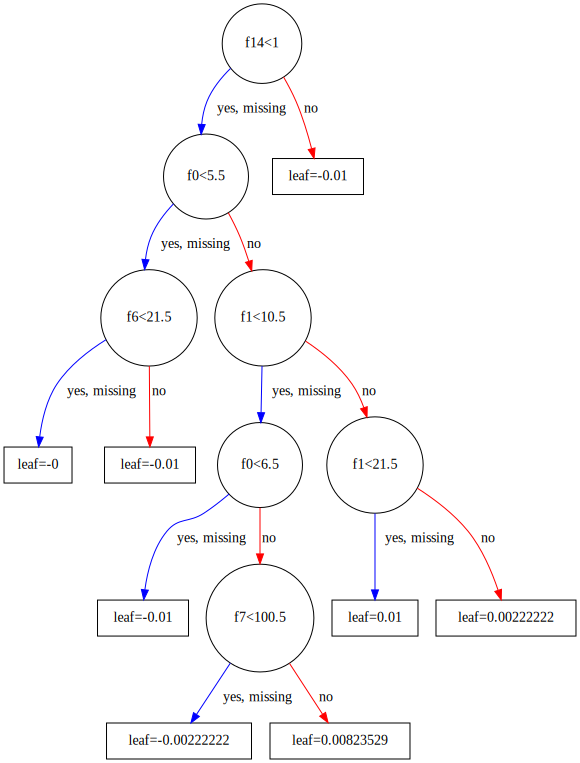

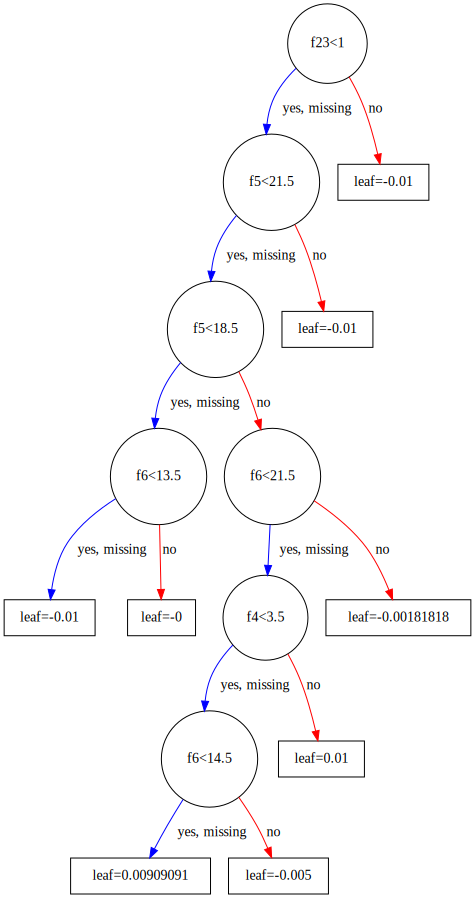

In [49]:
xgb.plot_importance(gbm)
xgb.to_graphviz(gbm)